<a href="https://colab.research.google.com/github/romanozamoth/image-recommender-dio/blob/main/image_recommender_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook: Sistema de Recomendação por Imagem

In [ ]:
# @title 📦 1. Instalação de dependências e configuração da API do Kaggle

# Instalar pacotes necessários
!pip install -q kaggle scikit-learn matplotlib tensorflow

# Criar pasta do Kaggle e mover o arquivo de API
import os
import shutil
from google.colab import files

uploaded = files.upload()
print(uploaded)
if "kaggle.json" in uploaded:
  # Criar a pasta ~/.kaggle
  os.makedirs("/root/.kaggle", exist_ok=True)

  # Copiar o arquivo enviado para o local correto
  shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

  # Definir permissões (fundamental!)
  os.chmod("/root/.kaggle/kaggle.json", 600)
  print("TUDO OK COM ARQUIVO 'kaggle.json' !!!")

else:
  print("NECESSITA FAZER UPLOAD DO ARQUIVO 'kaggle.json' !!!")

In [ ]:
# @title 🧾 2. Download do Dataset: Fashion Product Images (Kaggle)

# Baixar o dataset do Kaggle
# LISTA DATASETS COM TAMANHOS
#!kaggle datasets list -s fashion

# TAMANHO EXCEDE LIMITE COLAB
#!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset
#!unzip -q fashion-product-images-dataset.zip -d fashion-dataset

# TESTAR COM SMALL
print("INICIANDO DOWNLOAD DATASET...")
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
print("DOWNLOAD DATASET FINALIZADO!")
print("INICIANDO UNZIP DATASET...")
!unzip -q fashion-product-images-small.zip -d fashion-dataset
print("UNZIP DATASET FINALIZADO!")


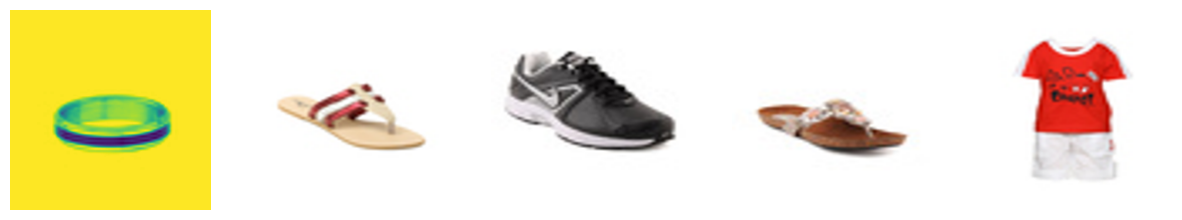

In [20]:
# @title 🖼️ 3. Visualizar algumas imagens

import os
import matplotlib.pyplot as plt
from PIL import Image

image_folder = "fashion-dataset/images"

sample_images = os.listdir(image_folder)[:5]

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_name)
    image = Image.open(img_path).resize((224, 224))
    axs[i].imshow(image)
    axs[i].axis('off')

In [21]:
# @title ⚙️ 4. Extração de Embeddings com EfficientNetB0

import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tqdm import tqdm

# Carregar modelo pré-treinado (sem a camada de classificação)
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Função para extrair vetor de características
def extract_embedding(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        embedding = model.predict(img_array, verbose=0)
        return embedding.flatten()
    except:
        return None


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# @title 🧠 5. Gerar e salvar os vetores de características

embeddings = []
filenames = []

for img_name in tqdm(os.listdir(image_folder)[:2000]):  # limitar para acelerar testes
    img_path = os.path.join(image_folder, img_name)
    emb = extract_embedding(img_path)
    if emb is not None:
        embeddings.append(emb)
        filenames.append(img_path)

embeddings = np.array(embeddings)

# Salvar arquivos
np.save("embeddings.npy", embeddings)

import pickle
with open("filenames.pkl", "wb") as f:
    pickle.dump(filenames, f)


100%|██████████| 2000/2000 [06:47<00:00,  4.91it/s]


In [23]:
# @title 🔍 6. Recomendação de imagens similares

from sklearn.neighbors import NearestNeighbors

# Carregar os arquivos se necessário
# embeddings = np.load("embeddings.npy")
# with open("filenames.pkl", "rb") as f:
#     filenames = pickle.load(f)

# Criar modelo de vizinhos mais próximos
nn = NearestNeighbors(n_neighbors=6, metric='euclidean')
nn.fit(embeddings)

# Função para recomendar imagens similares
def recomendar(img_path):
    query_emb = extract_embedding(img_path).reshape(1, -1)
    distances, indices = nn.kneighbors(query_emb)

    plt.figure(figsize=(15,5))
    plt.subplot(1, 6, 1)
    plt.imshow(Image.open(img_path).resize((224, 224)))
    plt.title("Consulta")
    plt.axis("off")

    for i, idx in enumerate(indices[0][1:]):
        plt.subplot(1, 6, i+2)
        plt.imshow(Image.open(filenames[idx]).resize((224, 224)))
        plt.title(f"Sim {i+1}")
        plt.axis("off")
    plt.show()


Saving tenis.jpeg to tenis.jpeg


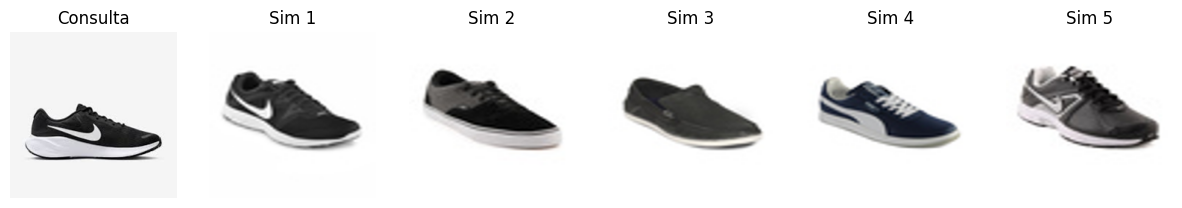

In [24]:
# @title 📤 7. Testar com uma imagem nova

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    recomendar(fn)
